# Supervised Learning Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sb
import time
import graphviz

### Data loading and cleaning

In [2]:
df = pd.read_csv("diagnosis-of-covid-19-and-its-clinical-spectrum.csv")
booldict = {
    "negative" : 0,
    "positive" : 1}
df["sars_cov_2_exam_result"] = df["sars_cov_2_exam_result"].map(booldict)
df = df.select_dtypes(exclude=['object'])
df = df.drop("patient_age_quantile", axis=1)
df.shape
df = df.loc[:, df.isnull().sum() < 0.9199999999999996*df.shape[0]]
df = df.dropna()
print("Positive Sample Count: ",df[df["sars_cov_2_exam_result"]==1].shape[0])
print("Negative Sample Count: ",df[df["sars_cov_2_exam_result"]==0].shape[0])

Positive Sample Count:  59
Negative Sample Count:  361


### Feature Selection through Correlation Matrix

In [3]:
# Features Selection
corr_mat = df.corr()
candidates = corr_mat.index.values
removed = []
for c1 in candidates:
    for c2 in candidates:
        if (c1 not in removed) and (c2 not in removed):
            if c1!=c2:
                if corr_mat.loc[c1,c2] > 0.6 or corr_mat.loc[c1,c2] < -0.6:
                    removed.append(c1)
data = df.drop(removed, axis=1)
data.describe()

,sars_cov_2_exam_result,platelets,mean_platelet_volume,red_blood_cells,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,basophils,eosinophils,mean_corpuscular_volume_mcv,monocytes,red_blood_cell_distribution_width_rdw,neutrophils,proteina_c_reativa_mg_dl
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,0.140476,-0.055109,0.016286,0.076020,0.008480,-0.112804,0.109329,0.075405,0.058032,0.083221,-0.067165,0.034531,-0.113936
std,0.347895,0.949576,0.978845,0.972173,0.978612,0.772376,0.780921,1.059226,0.866356,0.932145,0.909437,1.013838,0.773349
min,0.000000,-2.075077,-2.120995,-3.635631,-4.535603,-1.928470,-1.140144,-0.835508,-3.038537,-2.163721,-1.598094,-3.339775,-0.535362
25%,0.000000,-0.617907,-0.662483,-0.466575,-0.552476,-0.641429,-0.529226,-0.624811,-0.474754,-0.482876,-0.625073,-0.635476,-0.519466
50%,0.000000,-0.159401,-0.101517,0.093189,-0.054585,-0.249055,0.081693,-0.245556,0.066045,-0.062665,-0.182790,-0.020863,-0.431044
75%,0.000000,0.399599,0.683835,0.736697,0.642463,0.323504,0.463516,0.397069,0.571791,0.515126,0.259492,0.716673,-0.083317
max,1.000000,9.532034,3.713052,3.645706,3.331071,2.949764,3.441742,8.350876,3.150596,4.533397,6.982184,2.535929,5.733660


## Logistic Regression Without PCA
### First try

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
y = data.iloc[:, 0].values.astype("int")
x = data.iloc[:, 1:]
x_train, x_test, y_train, y_test =train_test_split(x, y,random_state =42)
logReg = LogisticRegression(solver="lbfgs", random_state =0)
start_time = time.time()
logReg.fit(x_train, y_train)
end_time = time.time()
print('duration of training (Log Regression):',end_time-start_time)
#VALIDATION
y_pred = logReg.predict(x_test)
print('accuracy score: %.5f' % accuracy_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix
print('confusion matrix: ')
print(confusion_matrix (y_test, y_pred, labels = [1,0]))

duration of training (Log Regression): 0.007050991058349609
accuracy score: 0.84762
confusion matrix: 
[[ 7 12]
 [ 4 82]]


Discussion: <br>
As shown in confusion matrix, True Positive Rate is only 7/19=0.368, which is far lower than accuracy score (range between 0.8~0.9).
Since Ratio of negative and positive cases is nearly 6-to-1, we believe this may lead to biased prediction in ML model. 
Therefore, we introduce over-sampling to resize the positive and negative cases in order to get a balanced training data group.
<br>
### Introduce oversampling to improve the accuracy in positivie results

In [5]:
#resample command
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_sample(x, y)
start_time = time.time()
end_time = time.time()
x_train_re, x_test_re, y_train_re, y_test_re =train_test_split(x_resampled, y_resampled,random_state =42)
start_time = time.time()
logReg.fit(x_train_re, y_train_re)
end_time = time.time()
print('duration of training (Log Regression):',end_time-start_time)
#VALIDATION
y_pred_re = logReg.predict(x_test_re)
print('accuracy score: %.5f' % accuracy_score(y_test_re, y_pred_re))
from sklearn.metrics import confusion_matrix
print('confusion matrix: ')
print(confusion_matrix (y_test_re, y_pred_re, labels = [1,0]))

duration of training (Log Regression): 0.004033803939819336
accuracy score: 0.85083
confusion matrix: 
[[80  7]
 [20 74]]


## KNN_Model Without PCA
### First try

In [6]:
from sklearn.neighbors import KNeighborsClassifier
accuracyScoreKnn = []
truePosRateKnn = []
for i in range(1,50):
    knn_model = KNeighborsClassifier(n_neighbors = i)
    knn_model.fit(x_train, y_train)
    y_pred = knn_model.predict(x_test)
    accuracyScoreKnn.append(accuracy_score(y_test, y_pred))
    cfnMat = confusion_matrix(y_test, y_pred, labels =[1, 0])
    truePosRateKnn.append(cfnMat[0,0]/(cfnMat[0,0]+cfnMat[0,1]))

In [7]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
start_time = time.time()
knn_model.fit(x_train, y_train)
end_time = time.time()
print('duration of training (KNN):',end_time-start_time)
y_pred = knn_model.predict(x_test)
print('accuracy score: %.5f' % accuracy_score(y_test, y_pred))
print('confusion matrix: ')
print(confusion_matrix(y_test, y_pred, labels =[1, 0]))
cfnMat = confusion_matrix(y_test, y_pred, labels =[1, 0])

duration of training (KNN): 0.0014028549194335938
accuracy score: 0.88571
confusion matrix: 
[[10  9]
 [ 3 83]]


### Introduce oversampling to improve the accuracy in positivie results

In [8]:
from sklearn.neighbors import KNeighborsClassifier
accuracyScoreKnnReS = []
truePosRateKnnReS = []
for i in range(1,50):
    knn_model = KNeighborsClassifier(n_neighbors = i)
    knn_model.fit(x_train_re, y_train_re)
    y_pred_re = knn_model.predict(x_test_re)
    accuracyScoreKnnReS.append(accuracy_score(y_test_re, y_pred_re))
    cfnMat = confusion_matrix(y_test_re, y_pred_re, labels =[1, 0])
    truePosRateKnnReS.append(cfnMat[0,0]/(cfnMat[0,0]+cfnMat[0,1]))

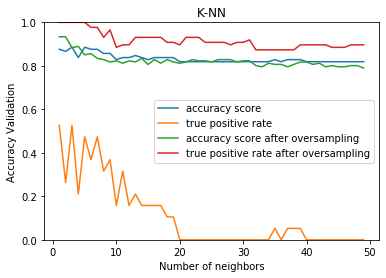

In [9]:
plt.plot(range(1,50), accuracyScoreKnn,label='accuracy score')
plt.plot(range(1,50), truePosRateKnn,label='true positive rate')
plt.plot(range(1,50), accuracyScoreKnnReS,label='accuracy score after oversampling')
plt.plot(range(1,50), truePosRateKnnReS,label='true positive rate after oversampling')
plt.title('K-NN')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy Validation')
plt.ylim(0,1)
plt.legend()

In [10]:
knn_model = KNeighborsClassifier(n_neighbors = 3)

start_time = time.time()
knn_model.fit(x_train_re, y_train_re)
end_time = time.time()
print('duration of training (KNN):',end_time-start_time)

y_pred_re = knn_model.predict(x_test_re)
print('accuracy score: %.5f' % accuracy_score(y_test_re, y_pred_re))
print('confusion matrix: ')
print(confusion_matrix (y_test_re, y_pred_re, labels = [1,0]))

duration of training (KNN): 0.0022187232971191406
accuracy score: 0.88398
confusion matrix: 
[[87  0]
 [21 73]]


## Decision Tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [11]:
from sklearn.tree import DecisionTreeClassifier
def decTreeScore(crit = 'gini',  maxDepth = None, minSamples = 1, minSplit = 2):
    decTree = DecisionTreeClassifier(criterion = crit, max_depth = maxDepth, min_samples_leaf = minSamples, 
                                 min_samples_split = minSplit, random_state= 42)
    decTree.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, decTree.predict(x_test))
    return accuracy
#default setting
#decTreeScore()

In [12]:
opt_maxDepth = 1
opt_minSamples = 1
opt_minSpilt = 1
opt_score = 0
for i in np.arange(1,10):
    for j in np.arange(1,30):
        for k in np.arange(2,30):
            if decTreeScore(maxDepth=i,minSamples = j, minSplit = k) > opt_score:
                opt_maxDepth = i
                opt_minSamples = j
                opt_minSpilt = k
                opt_score = decTreeScore(maxDepth=i,minSamples = j, minSplit = k)
print("ijk:",opt_maxDepth ," ",opt_minSamples," ",opt_minSpilt)
print(opt_score)

ijk: 5   1   2
0.8571428571428571


In [13]:
#Accuracy of Optimized Param 
decTree = DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_leaf = 1, 
                                 min_samples_split = 2, random_state= 42)
start_time = time.time()
decTree.fit(x_train, y_train)
end_time = time.time()
print('duration of training (Decision Tree):',end_time-start_time)

y_pred = decTree.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

duration of training (Decision Tree): 0.003131866455078125
0.8571428571428571


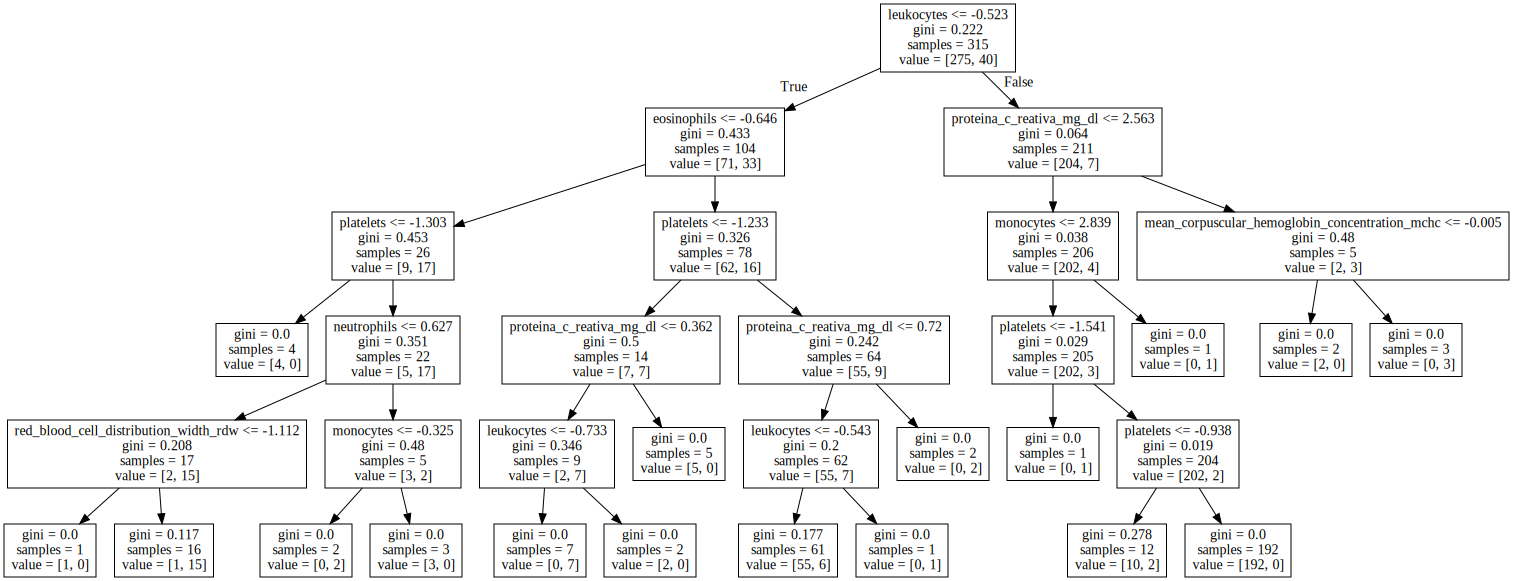

In [14]:
#-------->VISUAL RESULT
from sklearn import tree 
import graphviz
from graphviz import Source
Source(tree.export_graphviz(decTree, out_file=None, class_names=None, feature_names= x_train.columns))

## Neural Network

In [15]:
from keras.layers.core import Dense, Activation
from keras.models import Sequential

y_train_ohe = np.array([[1,0] if x== 1 else [0,1] for x in y_train])
y_test_ohe = np.array([[1,0] if x== 1 else [0,1] for x in y_test])

model = Sequential()
model.add(Dense(500, input_shape=(x_train.shape[1],),activation='sigmoid')) 
#relu
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=["accuracy"])
start_time = time.time()
model.fit(x_train, y_train_ohe,batch_size=64,epochs=500)
end_time = time.time()
print('duration of training (Neural Network):',end_time-start_time)

#evaluation
loss, accuracy = model.evaluate(x_test, y_test_ohe)
print('Loss = ', loss, ', Accuracy = ', accuracy)

Using TensorFlow backend.


Epoch 1/500
315/315 [==============================] - 0s 527us/step - loss: 0.6144 - accuracy: 0.6032
Epoch 2/500
315/315 [==============================] - 0s 29us/step - loss: 0.3856 - accuracy: 0.8730
Epoch 3/500
315/315 [==============================] - 0s 34us/step - loss: 0.4124 - accuracy: 0.8730
Epoch 4/500
315/315 [==============================] - 0s 35us/step - loss: 0.3885 - accuracy: 0.8730
Epoch 5/500
315/315 [==============================] - 0s 28us/step - loss: 0.3306 - accuracy: 0.8730
Epoch 6/500
315/315 [==============================] - 0s 24us/step - loss: 0.3072 - accuracy: 0.8698
Epoch 7/500
315/315 [==============================] - 0s 23us/step - loss: 0.3045 - accuracy: 0.8730
Epoch 8/500
315/315 [==============================] - 0s 24us/step - loss: 0.2919 - accuracy: 0.8730
Epoch 9/500
315/315 [==============================] - 0s 25us/step - loss: 0.2838 - accuracy: 0.8730
Epoch 10/500
315/315 [==============================] - 0s 34us/step - loss: 0.27

315/315 [==============================] - 0s 37us/step - loss: 0.2113 - accuracy: 0.9048
Epoch 81/500
315/315 [==============================] - 0s 55us/step - loss: 0.2110 - accuracy: 0.9079
Epoch 82/500
315/315 [==============================] - 0s 43us/step - loss: 0.2116 - accuracy: 0.9079
Epoch 83/500
315/315 [==============================] - 0s 52us/step - loss: 0.2124 - accuracy: 0.9111
Epoch 84/500
315/315 [==============================] - 0s 54us/step - loss: 0.2125 - accuracy: 0.9079
Epoch 85/500
315/315 [==============================] - 0s 42us/step - loss: 0.2124 - accuracy: 0.9016
Epoch 86/500
315/315 [==============================] - 0s 41us/step - loss: 0.2107 - accuracy: 0.9048
Epoch 87/500
315/315 [==============================] - 0s 77us/step - loss: 0.2123 - accuracy: 0.9048
Epoch 88/500
315/315 [==============================] - 0s 56us/step - loss: 0.2103 - accuracy: 0.9111
Epoch 89/500
315/315 [==============================] - 0s 77us/step - loss: 0.2113 - 

315/315 [==============================] - 0s 69us/step - loss: 0.2109 - accuracy: 0.9079
Epoch 160/500
315/315 [==============================] - 0s 45us/step - loss: 0.2100 - accuracy: 0.9048
Epoch 161/500
315/315 [==============================] - 0s 56us/step - loss: 0.2085 - accuracy: 0.9079
Epoch 162/500
315/315 [==============================] - 0s 54us/step - loss: 0.2080 - accuracy: 0.9079
Epoch 163/500
315/315 [==============================] - 0s 46us/step - loss: 0.2084 - accuracy: 0.9079
Epoch 164/500
315/315 [==============================] - 0s 73us/step - loss: 0.2098 - accuracy: 0.9048
Epoch 165/500
315/315 [==============================] - 0s 35us/step - loss: 0.2102 - accuracy: 0.8984
Epoch 166/500
315/315 [==============================] - 0s 46us/step - loss: 0.2098 - accuracy: 0.8984
Epoch 167/500
315/315 [==============================] - 0s 32us/step - loss: 0.2079 - accuracy: 0.9048
Epoch 168/500
315/315 [==============================] - 0s 37us/step - loss: 

315/315 [==============================] - 0s 31us/step - loss: 0.2065 - accuracy: 0.9048
Epoch 238/500
315/315 [==============================] - 0s 28us/step - loss: 0.2072 - accuracy: 0.9079
Epoch 239/500
315/315 [==============================] - 0s 32us/step - loss: 0.2064 - accuracy: 0.9079
Epoch 240/500
315/315 [==============================] - 0s 38us/step - loss: 0.2089 - accuracy: 0.9016
Epoch 241/500
315/315 [==============================] - 0s 32us/step - loss: 0.2072 - accuracy: 0.9079
Epoch 242/500
315/315 [==============================] - 0s 31us/step - loss: 0.2072 - accuracy: 0.9048
Epoch 243/500
315/315 [==============================] - 0s 33us/step - loss: 0.2073 - accuracy: 0.9079
Epoch 244/500
315/315 [==============================] - 0s 32us/step - loss: 0.2062 - accuracy: 0.9079
Epoch 245/500
315/315 [==============================] - 0s 30us/step - loss: 0.2067 - accuracy: 0.9079
Epoch 246/500
315/315 [==============================] - 0s 28us/step - loss: 

315/315 [==============================] - 0s 32us/step - loss: 0.2039 - accuracy: 0.9079
Epoch 316/500
315/315 [==============================] - 0s 30us/step - loss: 0.2031 - accuracy: 0.9079
Epoch 317/500
315/315 [==============================] - 0s 35us/step - loss: 0.2056 - accuracy: 0.9048
Epoch 318/500
315/315 [==============================] - 0s 39us/step - loss: 0.2041 - accuracy: 0.9048
Epoch 319/500
315/315 [==============================] - 0s 33us/step - loss: 0.2041 - accuracy: 0.9079
Epoch 320/500
315/315 [==============================] - 0s 30us/step - loss: 0.2063 - accuracy: 0.9048
Epoch 321/500
315/315 [==============================] - 0s 38us/step - loss: 0.2022 - accuracy: 0.9048
Epoch 322/500
315/315 [==============================] - 0s 36us/step - loss: 0.2032 - accuracy: 0.9079
Epoch 323/500
315/315 [==============================] - 0s 38us/step - loss: 0.2056 - accuracy: 0.8984
Epoch 324/500
315/315 [==============================] - 0s 43us/step - loss: 

315/315 [==============================] - 0s 33us/step - loss: 0.1968 - accuracy: 0.9111
Epoch 394/500
315/315 [==============================] - 0s 40us/step - loss: 0.1971 - accuracy: 0.9111
Epoch 395/500
315/315 [==============================] - 0s 37us/step - loss: 0.1974 - accuracy: 0.9111
Epoch 396/500
315/315 [==============================] - 0s 37us/step - loss: 0.1996 - accuracy: 0.9111
Epoch 397/500
315/315 [==============================] - 0s 35us/step - loss: 0.1961 - accuracy: 0.9111
Epoch 398/500
315/315 [==============================] - 0s 38us/step - loss: 0.1996 - accuracy: 0.9079
Epoch 399/500
315/315 [==============================] - 0s 36us/step - loss: 0.1965 - accuracy: 0.9079
Epoch 400/500
315/315 [==============================] - 0s 39us/step - loss: 0.1966 - accuracy: 0.9111
Epoch 401/500
315/315 [==============================] - 0s 60us/step - loss: 0.1975 - accuracy: 0.9111
Epoch 402/500
315/315 [==============================] - 0s 48us/step - loss: 

315/315 [==============================] - 0s 35us/step - loss: 0.1890 - accuracy: 0.9111
Epoch 472/500
315/315 [==============================] - 0s 31us/step - loss: 0.1868 - accuracy: 0.9143
Epoch 473/500
315/315 [==============================] - 0s 33us/step - loss: 0.1889 - accuracy: 0.9048
Epoch 474/500
315/315 [==============================] - 0s 37us/step - loss: 0.1860 - accuracy: 0.9111
Epoch 475/500
315/315 [==============================] - 0s 34us/step - loss: 0.1870 - accuracy: 0.9143
Epoch 476/500
315/315 [==============================] - 0s 44us/step - loss: 0.1887 - accuracy: 0.9079
Epoch 477/500
315/315 [==============================] - 0s 35us/step - loss: 0.1858 - accuracy: 0.9048
Epoch 478/500
315/315 [==============================] - 0s 38us/step - loss: 0.1866 - accuracy: 0.9143
Epoch 479/500
315/315 [==============================] - 0s 39us/step - loss: 0.1861 - accuracy: 0.9111
Epoch 480/500
315/315 [==============================] - 0s 34us/step - loss: 